In [1]:
# All the Imports

import numpy as np
import os

import time
from functools import partial
from multiprocessing import Pool
from sklearn.cluster import KMeans
import matplotlib as mpl
from skimage import measure

import pymesh
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import sys

sys.path.append('..')
# from datasets import *
# from transforms import *
import glob
from numpy.linalg import norm
import SimpleITK as sitk

In [2]:
# [STAR] All the Helper functions

def get_neighbors(mesh, root, element, search_range=1, edge_only=False):
    """
    get neighbors of given element(vertices/faces) on mesh
    :param mesh: a PyMesh mesh object
    :param root: id of root face/vertex
    :param element: 'face' or 'f' for searching faces, and 'vertex' or 'v' for searching vertices
    :param search_range: level of searching rings on mesh
    :param edge_only: if True, only return neighbors at the edge of search range, otherwise return all neighbors within it.
    :return:
    """
    mesh.enable_connectivity()
    to_be_visited_list = []  # searching faces
    visited_set = set()  # visited neighbor faces
    # a dictionary to maintain meta information (used for path formation)
    search_dist = dict()
    search_dist[root] = 0
    to_be_visited_list.append(root)
    while not to_be_visited_list == []:
        current_node = to_be_visited_list[0]

        if search_dist[current_node] < search_range:
            # For each child of the current tree process
            temp_neighbors = None
            if element == 'face' or element == 'f':
                temp_neighbors = mesh.get_face_adjacent_faces(current_node)
            elif element == 'vertex' or element == 'v':
                temp_neighbors = mesh.get_vertex_adjacent_vertices(current_node)
            else:
                ValueError("Wrong Element Type: can only be  'v'/'vertex' for vertex, or 'f'/'face' for face")

            for neighbor in temp_neighbors:

                # The node has already been processed, so skip over it
                # if neighbor in visited_set:
                if neighbor in search_dist.keys():
                    continue

                # The child is not enqueued to be processed, so enqueue this level of children to be expanded
                if neighbor not in to_be_visited_list:
                    # create metadata for these nodes
                    if not neighbor in search_dist.keys():
                        search_dist[neighbor] = search_dist[current_node] + 1
                    else:
                        search_dist[neighbor] = min(search_dist[neighbor], search_dist[current_node] + 1)
                    # enqueue these nodes
                    to_be_visited_list.append(neighbor)

        # We finished processing the root of this subtree, so add it to the closed set
        to_be_visited_list.remove(current_node)
        if not current_node == root:
            if (not edge_only) or search_dist[current_node] == search_range:
                visited_set.add(current_node)
        pass

    return list(visited_set)

def smooth_face_label_single_core(mesh, face_labels, smooth_rings):
    """
    Single process version of smooth the labels of all faces
    :param mesh:
    :param face_labels:
    :param smooth_rings:
    :return:
    """

    smoothed_labels = np.zeros(face_labels.shape)
    for id in range(len(face_labels)):
        neighbor_faces = get_neighbors(mesh, id, 'face', search_range=smooth_rings)
        if np.sum(face_labels[neighbor_faces]) < 0:
            smoothed_labels[id] = -1
        elif np.sum(face_labels[neighbor_faces]) > 0:
            smoothed_labels[id] = 1
        else:
            smoothed_labels[id] = face_labels[id]
    return smoothed_labels

def get_main_mesh(meshes, threshold=1, merge=True):
    """
    Get the main mesh(es) with a threhold of number of vertices from a list of meshes
    The goal is to remove small connected-component caused by segmentation artifacts
    :param meshes:
    :param threshold: meshes with number of vertices below the threshold will be removed
    :return: largest mesh(es): a list if num_max>1
    """
    assert (threshold > 1 and isinstance(threshold, int)), "threshold must be an >1 integer"

    num_vertices = np.array([meshes[i].num_vertices for i in range(len(meshes))])

    ordered_mesh_size_indices = num_vertices.argsort()[::-1]

    main_mesh_indices = []

    for ind in ordered_mesh_size_indices:
        if num_vertices[ind] < threshold:
            break
        else:
            main_mesh_indices.append(ind)

    if not merge:
        return [meshes[i] for i in main_mesh_indices]
    else:
        return pymesh.merge_meshes([meshes[i] for i in main_mesh_indices])

def smooth_mesh_segmentation(mesh, face_labels, smooth_rings, max_rings=None, n_workers=1):
    """
    Spatially smooth the binary labels of face labels on a surface mesh, the smoothing is done by nearest neighbors
    The neighbors is controlled by smooth-rings which is defined as the discrete "geodesic" distance to the faces.
    E.g. smooth_rings=1 will use the faces directly connected to the target face as neighbors,
        smooth_rings=2 will add the faces directly connected to the ring1 neighbors as neighbors.
    if smooth_rings = 0, smoothing will not be excuted
    The smoothing will be repeated with +1 smooth_ring until it reachs max_rings or the segmentation is sufficiently
    smoothed (after segmentation, each connected component in the original mesh is segemented into two connected components).
    When max_ring is None, it will be set as smooth_ring and therefore only one smoothing iteration will be excuted.
    :param mesh:
    :param face_labels: The binary labeling have to be -1 or 1
    :param smooth_rings: size of smoothing rings(neighbor range on mesh graph)
    :param max_rings: if max_rings is given, the smooth_rings keeps growing until the smoothed mesh has no additional
    disconnected meshes or reaching maximum iterations
    :returns inner_mesh(label -1, surface touching bones), outer_mesh(label 1),
    inner_face_list(face indices of inner mesh), outer_face_list(face indices of outer mesh)
    """
    if smooth_rings == 0:
        inner_face_list = np.where(face_labels == -1)[0]
        outer_face_list = np.where(face_labels == 1)[0]

        inner_mesh = pymesh.submesh(mesh, inner_face_list, num_rings=0)
        outer_mesh = pymesh.submesh(mesh, outer_face_list, num_rings=0)
        return inner_mesh, outer_mesh, inner_face_list, outer_face_list

    if max_rings is None:
        max_rings = smooth_rings

    assert smooth_rings <= max_rings, "ERROR: Smoothing rings must be no more than max rings"

    mesh.enable_connectivity()

    while True:
        # mn test; todo maybe, remove again; use fix_mesh instead?
        # mesh, _ = pymesh.remove_duplicated_vertices(mesh)

        # one iteration of smoothing
        if n_workers>1:
            with Pool(processes=n_workers, initializer=mesh_process_pool_init, initargs=(mesh,)) as pool:
                smoothed_label = pool.map(partial(smooth_face_label, face_labels=face_labels, smooth_rings=smooth_rings),
                                          range(len(face_labels)))
        else:
            smoothed_label = smooth_face_label_single_core(mesh, face_labels, smooth_rings)
        smoothed_label = np.array(smoothed_label)

        # get faces with each label
        inner_face_list = np.where(smoothed_label == -1)[0]
        outer_face_list = np.where(smoothed_label == 1)[0]

        # get two segmented meshes
        inner_mesh = pymesh.submesh(mesh, inner_face_list, num_rings=0)
        outer_mesh = pymesh.submesh(mesh, outer_face_list, num_rings=0)

        # keep growing neighbor ring size for smoothing untill no artifacts
        num_mesh_components = len(pymesh.separate_mesh(mesh))
        if (len(pymesh.separate_mesh(inner_mesh)) == num_mesh_components and
                len(pymesh.separate_mesh(outer_mesh)) == num_mesh_components):
            print("Well smoothed mesh segmentation")
            break
        elif smooth_rings >= max_rings:
            print("Reach maximum smoothing rings")
            break
        else:
            print("Smooth kernal {} is small. Now using size {}".format(smooth_rings, smooth_rings + 1))
            smooth_rings += 1

        face_labels = smoothed_label

    return inner_mesh, outer_mesh, inner_face_list, outer_face_list

def split_femoral_cartilage_surface(mesh, smooth_rings=1, max_rings=None, n_workers=1):
    """
    Split a cartilage surface mesh into the inner and outer surface
    :param mesh:femoral cartilage surface mesh
    :param smooth_rings:
    :param max_rings
    :return: inner_mesh(label -1, surface touching bones), outer_mesh(label 1),
    inner_face_list(face indices of inner mesh), outer_face_list(face indices of outer mesh)
    """
    mesh.add_attribute("face_normal")
    mesh.add_attribute("face_centroid")

    # face normals are towards the inner of cartilage surface
    face_normal = mesh.get_attribute("face_normal").reshape([-1, 3])
    face_centroid = mesh.get_attribute("face_centroid").reshape([-1, 3])

    # get the center of bounding box of femoral cartilage
    bbox_min, bbox_max = mesh.bbox
    center = (bbox_min + bbox_max) / 2

    inner_outer_label_list = np.zeros(mesh.num_faces)  # up:1, down:-1
    for k in range(mesh.num_faces):
        # get the direction from the center to the current face centroid
        connect_direction = center - face_centroid[k, :]

        # if the direction is the same with the normal, then it is outer side (labeled as -1) of cartilage surface
        # we only cares the direction on x-y plane
        if np.dot(connect_direction[:2], face_normal[k, :2]) < 0:
            inner_outer_label_list[k] = 1
        else:
            inner_outer_label_list[k] = -1

    return smooth_mesh_segmentation(mesh, inner_outer_label_list, smooth_rings=smooth_rings, 
                                    max_rings=max_rings,
                                    n_workers=n_workers)

def split_tibial_cartilage_surface(mesh, smooth_rings=1, max_rings=None, n_workers=1):
    """
    split femoral cartilage into two inner(touching the tibial bone) and outer surfaces by 
    clustering face normals
    :param mesh: tibial cartilage surface mesh
    :param smooth_rings:
    :param max_rings:
    :return: inner_mesh(label -1, surface touching bones), outer_mesh(label 1),
    inner_face_list(face indices of inner mesh), outer_face_list(face indices of outer mesh)
    """
    mesh.enable_connectivity()

    mesh.add_attribute("face_centroid")
    mesh.add_attribute("face_normal")

    mesh_centroids = mesh.get_attribute('face_centroid').reshape(-1, 3)
    mesh_centroids_normalized = (mesh_centroids - np.mean(mesh_centroids, axis=0)) / \
                                (np.max(mesh_centroids, axis=0) - np.min(mesh_centroids, axis=0))

    mesh_normals = mesh.get_attribute('face_normal').reshape(-1, 3)

    # clustering normals
    features = np.concatenate((mesh_centroids_normalized * 2, mesh_normals * 1), axis=1)
    est = KMeans(n_clusters=2)
    # est = SpectralClustering(n_clusters=2)
    labels = est.fit(features).labels_

    # transfer 0/1 labels to -1/1 labels
    inner_outer_label_list = labels * 2 - 1

    # set inner surface which contains mostly positive normals
    if mesh_normals[inner_outer_label_list == -1, 1].mean() < 0:
        inner_outer_label_list = -inner_outer_label_list

    return smooth_mesh_segmentation(mesh, inner_outer_label_list, smooth_rings=smooth_rings, 
                                    max_rings=max_rings,
                                    n_workers=n_workers)

def compute_mesh_thickness(mesh, cartilage, smooth_rings=1, max_rings=None, n_workers=1):
    """
    compute the thickness from each vertex on the cartilage to the opposite surface
    :param mesh(pymesh.mesh object):
    :param cartilage(string): 'FC' femoral cartilage or 'TC' tibial cartilage
    :return:thickness at each vertex of mesh
    """
    mesh.add_attribute("vertex_index")
    # mesh.add_attribute("vertex_normal")

    # split the cartilage into inner surface that interfacing the bone and the outer surface
    if cartilage == 'FC':
        inner_mesh, outer_mesh, inner_face_list, outer_face_list = split_femoral_cartilage_surface(mesh,
                                                                                                   smooth_rings=smooth_rings,
                                                                                                   max_rings=max_rings,
                                                                                                   n_workers=n_workers)
    elif cartilage == 'TC':
        inner_mesh, outer_mesh, inner_face_list, outer_face_list = split_tibial_cartilage_surface(mesh,
                                                                                                  smooth_rings=smooth_rings,
                                                                                                  max_rings=max_rings,
                                                                                                  n_workers=n_workers)
    else:
        ValueError("Cartilage can only be FC or TC")

    # you do not need this since inner mesh get vertex index/normal from original mesh
    # do this later, in case there was some mesh processing
    # inner_mesh.add_attribute("vertex_index")
    # inner_mesh.add_attribute("vertex_normal")
    #
    # outer_mesh.add_attribute("vertex_index")
    # outer_mesh.add_attribute("vertex_normal")

    # computer vertex distances to opposite surface
    inner_thickness = np.sqrt(pymesh.distance_to_mesh(outer_mesh, inner_mesh.vertices)[0])
    outer_thickness = np.sqrt(pymesh.distance_to_mesh(inner_mesh, outer_mesh.vertices)[0])

    # combine into a single thickness list
    thickness = np.zeros(mesh.num_vertices)
    
    print("thickness ", inner_thickness.shape, outer_thickness.shape, thickness.shape)
    
    thickness[inner_mesh.get_attribute('vertex_index').astype(int)] = inner_thickness
    thickness[outer_mesh.get_attribute('vertex_index').astype(int)] = outer_thickness
    return thickness

def get_cartilage_surface_mesh_from_segmentation_array(FC_prob, TC_prob, spacing, thickness=True,
                                                       save_path_FC=None, save_path_TC=None,
                                                       prob=True, transform=None):
    """
    Extract cartilage mesh from segmentation (3d numpy array) and compute the distance of mesh vetices to the opposite surface
    :param segmentation: HxWxD(xC), three class segmentation (probability) map of femoral cartilage, tibial cartilage
     and background
    :param spacing: spacing of segmentation map in H,W,D
    :param prob: if the input segmentation is probability map
    :param transform: the transformation that to map the voxel coordinates (default) of vertices to world coordinates
                    if None, keep the voxel coordinates (included the spacing though),
                    otherwise it should be a tuple of two numpy arrays (R, T)
                    R is a 3x3 rotation matrix and T is the translation vetor of length 3
                    The world coordinates are computed by P_w = P_v x R + T
    :return: meshes of femoral and tibial cartilage with the additional attribute "distance":
    """

    # Use marching cubes to obtain the surface mesh of shape
    print("Extract surfaces")
    FC_verts, FC_faces, FC_normals, FC_values = measure.marching_cubes_lewiner(FC_prob, 0.5,
                                                                               spacing=spacing,
                                                                               step_size=1,
                                                                               gradient_direction="ascent")

    TC_verts, TC_faces, TC_normals, TC_values = measure.marching_cubes_lewiner(TC_prob, 0.5,
                                                                               spacing=spacing,
                                                                               step_size=1,gradient_direction="ascent")

    FC_mesh = pymesh.form_mesh(FC_verts, FC_faces)
    TC_mesh = pymesh.form_mesh(TC_verts, TC_faces)

    FC_mesh, _ = pymesh.remove_duplicated_vertices(FC_mesh)
    TC_mesh, _ = pymesh.remove_duplicated_vertices(TC_mesh)

    FC_mesh_main = get_main_mesh(pymesh.separate_mesh(FC_mesh), threshold=1000, merge=True)
    TC_mesh_main = get_main_mesh(pymesh.separate_mesh(TC_mesh), threshold=1000, merge=True)

    if thickness:
        print("Compute FC mesh thickness")
        FC_thickness = compute_mesh_thickness(FC_mesh_main, cartilage='FC', smooth_rings=10, max_rings=None,
                                              n_workers=1)
        print('Done computing FC mesh thickness')

        print("Compute TC mesh thickness")
        TC_thickness = compute_mesh_thickness(TC_mesh_main, cartilage='TC', smooth_rings=10, max_rings=None,
                                              n_workers=1)
        print('Done computing TC mesh thickness')

    if transform:
        FC_mesh_main = pymesh.form_mesh(voxel_to_world_coord(FC_mesh_main.vertices, transform),
                                        FC_mesh_main.faces)
        TC_mesh_main = pymesh.form_mesh(voxel_to_world_coord(TC_mesh_main.vertices, transform),
                                        TC_mesh_main.faces)

    if thickness:
        FC_mesh_main.add_attribute("vertex_thickness")
        FC_mesh_main.set_attribute("vertex_thickness", FC_thickness)

        TC_mesh_main.add_attribute("vertex_thickness")
        TC_mesh_main.set_attribute("vertex_thickness", TC_thickness)

        if save_path_FC:
            pymesh.save_mesh(save_path_FC, FC_mesh_main, "vertex_thickness", ascii=True)
        if save_path_TC:
            pymesh.save_mesh(save_path_TC, TC_mesh_main, "vertex_thickness", ascii=True)
    else:
        if save_path_FC:
            pymesh.save_mesh(save_path_FC, FC_mesh_main, ascii=True)
        if save_path_TC:
            pymesh.save_mesh(save_path_TC, TC_mesh_main, ascii=True)

    return FC_mesh_main, TC_mesh_main

def get_cartilage_surface_mesh_from_segmentation_file(segmentation_file, thickness=True,
                                                      save_path_FC=None, save_path_TC=None,
                                                      prob=True, coord='voxel'):
    """
    compute cartilage thickness from a segmentation file
    :param segmentation_file: the image file and a tupe of seperated files of the FC/TC segmentation mask/probmaps
    :param save_path_FC:
    :param save_path_TC:
    :param prob: if True, the input segmentation is probability maps, otherwise is segmentation mask
    :param coord: the coordinate system the output mesh lie in.
                  'voxel': the image space;
                  'nifti': the world space follows convention in nifti definition, used in ITK-SNAP and NiftyReg
                  'itk': the world space follows ITK convention, used in ITK and simpleITK
    :return:
    """
    if type(segmentation_file) == str:
        segmentation = sitk.ReadImage(segmentation_file)

        # the np array from itk are ordered in z,y,x
        segmentation_np = np.swapaxes(sitk.GetArrayFromImage(segmentation), 0, 2)

        if prob:
            FC_prob = segmentation_np[:, :, :, 0]
            TC_prob = segmentation_np[:, :, :, 1]
        else:
            FC_prob = (segmentation == 1).astype(float)
            TC_prob = (segmentation == 2).astype(float)

        # get rotation matrix and translation vector for mapping from voxel space to world space
        if coord == 'voxel':
            transform = None
        elif coord == 'nifti':
            transform = get_voxel_to_world_transform_nifti(segmentation[0])

        spacing = segmentation.GetSpacing()

    elif type(segmentation_file) == tuple:
        if type(segmentation_file[0]) == str and type(segmentation_file[1]) == str:
            segmentation = [sitk.ReadImage(file) for file in segmentation_file]
            FC_prob = np.swapaxes(sitk.GetArrayFromImage(segmentation[0]), 0, 2).astype(float)
            TC_prob = np.swapaxes(sitk.GetArrayFromImage(segmentation[1]), 0, 2).astype(float)

            # the np array from itk are ordered in z,y,x
            if coord == 'voxel':
                transform = None
            elif coord == 'nifti':
                transform = get_voxel_to_world_transform_nifti(segmentation[0])
            spacing = segmentation[0].GetSpacing()
        else:
            TypeError("The segmentation files must be a tuple of strings, but a tuple of ({}, {}) is given".format(
                type(segmentation_file[0]), type(segmentation_file[1])))

    else:
        TypeError("The segmentation file must be a str type or a tuple of strings, but {} is given".format(type(segmentation_file)))


    return get_cartilage_surface_mesh_from_segmentation_array(FC_prob, TC_prob,
                                                              spacing=spacing,
                                                              thickness=thickness,
                                                              save_path_TC=save_path_TC,
                                                              save_path_FC=save_path_FC,
                                                              prob=prob,
                                                              transform=transform)

def my_get_cartilage_surface_mesh_from_segmentation_file(segmentation_file, thickness=True,
                                                      save_path_FC=None, save_path_TC=None,
                                                      prob=True, coord='voxel'):
    """
    compute cartilage thickness from a segmentation file
    :param segmentation_file: the image file and a tupe of seperated files of the FC/TC segmentation mask/probmaps
    :param save_path_FC:
    :param save_path_TC:
    :param prob: if True, the input segmentation is probability maps, otherwise is segmentation mask
    :param coord: the coordinate system the output mesh lie in.
                  'voxel': the image space;
                  'nifti': the world space follows convention in nifti definition, used in ITK-SNAP and NiftyReg
                  'itk': the world space follows ITK convention, used in ITK and simpleITK
    :return:
    """
    if type(segmentation_file) == str:
        segmentation = sitk.ReadImage(segmentation_file)

        # the np array from itk are ordered in z,y,x
        segmentation_np = np.swapaxes(sitk.GetArrayFromImage(segmentation), 0, 2)

        if prob:
            FC_prob = segmentation_np[:, :, :, 0]
            TC_prob = segmentation_np[:, :, :, 1]
        else:
            FC_prob = (segmentation == 1).astype(float)
            TC_prob = (segmentation == 2).astype(float)

        # get rotation matrix and translation vector for mapping from voxel space to world space
        if coord == 'voxel':
            transform = None
        elif coord == 'nifti':
            transform = get_voxel_to_world_transform_nifti(segmentation[0])

        spacing = segmentation.GetSpacing()

    elif type(segmentation_file) == tuple:
        if type(segmentation_file[0]) == str and type(segmentation_file[1]) == str:
            segmentation = [sitk.ReadImage(file) for file in segmentation_file]
            FC_prob = np.swapaxes(sitk.GetArrayFromImage(segmentation[0]), 0, 2).astype(float)
            TC_prob = np.swapaxes(sitk.GetArrayFromImage(segmentation[1]), 0, 2).astype(float)

            # the np array from itk are ordered in z,y,x
            if coord == 'voxel':
                transform = None
            elif coord == 'nifti':
                transform = get_voxel_to_world_transform_nifti(segmentation[0])
            spacing = segmentation[0].GetSpacing()
        else:
            TypeError("The segmentation files must be a tuple of strings, but a tuple of ({}, {}) is given".format(
                type(segmentation_file[0]), type(segmentation_file[1])))

    else:
        TypeError("The segmentation file must be a str type or a tuple of strings, but {} is given".format(type(segmentation_file)))


    return get_cartilage_surface_mesh_from_segmentation_array(FC_prob, TC_prob,
                                                              spacing=spacing,
                                                              thickness=thickness,
                                                              save_path_TC=save_path_TC,
                                                              save_path_FC=save_path_FC,
                                                              prob=prob,
                                                              transform=transform)

def plot_mesh_segmentation(mesh1, mesh2):
    import visvis as vv

    app = vv.use()
    a1 = vv.subplot(111)
    FC_vis_up = vv.mesh(mesh1.vertices, mesh1.faces)
    # FC_vis.colormap = vv.CM_JET
    FC_vis_up.faceColor = 'r'
    FC_vis_down = vv.mesh(mesh2.vertices, mesh2.faces)
    FC_vis_down.faceColor = 'b'
    app.Run()

In [3]:
# [STAR] Check if re-sampling the segmentation mask changes the results

import itk

#basepath = '/data/DATASETS/example_oai_data/example_data/OAI_results/9010060/MR_SAG_3D_DESS/LEFT_KNEE/12_MONTH/'
basepath = '/media/pranjal.sahu/cde12877-34df-449d-8202-07ba08ef2e6e/OLD/DATASETS/example_oai_data/example_data/OAI_results/9010060/MR_SAG_3D_DESS/LEFT_KNEE/12_MONTH/'
img = itk.imread(basepath + 'FC_probmap.nii.gz')
input_image = img.astype(itk.F)

#print(input_image)

input_size = itk.size(input_image)
input_spacing = itk.spacing(input_image)
input_origin = itk.origin(input_image)
Dimension = input_image.GetImageDimension()


output_size = [int(input_size[0]*input_spacing[0]/0.5), int(input_size[1]*input_spacing[1]/0.5), int(input_size[2]*input_spacing[2]/0.5)]
# output_spacing = [input_spacing[d] / scale for d in range(Dimension)]
# output_origin = [input_origin[d] + 0.5 * (output_spacing[d] - input_spacing[d])
#                  for d in range(Dimension)]

print('Input Values ')
print('input_size ', input_size)
print('input_spacing ', input_spacing)
print('input_origin ', input_origin)

#output_size = input_size
output_spacing = [0.5, 0.5, 0.5]
output_origin = input_origin
scale_transform = itk.ScaleTransform.D3.New()

# scale_transform = itk.ScaleTransform[itk.D, Dimension].New()
# scale_transform_parameters = scale_transform.GetParameters()
# for i in range(len(scale_transform_parameters)):
#     scale_transform_parameters[i] = scale
# scale_transform_center = [float(int(s / 2)) for s in input_size]
# scale_transform.SetParameters(scale_transform_parameters)
# scale_transform.SetCenter(scale_transform_center)

#transform=scale_transform,
#size=output_size,
    
interpolator = itk.LinearInterpolateImageFunction.New(input_image)

# resampled = itk.resample_image_filter(
#     input_image,
#     transform=transform1,
#     interpolator=interpolator,
#     output_spacing=output_spacing,
#     output_origin=output_origin,
#     size=output_size)

# Using default Interpolator
resample_filter = itk.ResampleImageFilter.IF3IF3.New()
resample_filter.SetInput(input_image)
resample_filter.SetTransform(scale_transform)
resample_filter.SetDefaultPixelValue(0)
resample_filter.SetOutputSpacing(output_spacing)
resample_filter.SetOutputOrigin(output_origin)
resample_filter.SetOutputDirection(input_image.GetDirection())
resample_filter.SetSize(output_size)
resample_filter.Update()

resampled = resample_filter.GetOutput()

output_size = itk.size(resampled)
output_spacing = itk.spacing(resampled)
output_origin = itk.origin(resampled)

print('---------------------------------')
print('Outputs Values ')
print('output_size ', output_size)
print('output_spacing ', output_spacing)
print('output_origin ', output_origin)

Input Values 
input_size  itkSize3 ([384, 384, 160])
input_spacing  itkVectorD3 ([0.364583, 0.364583, 0.700002])
input_origin  itkPointD3 ([0, 0, 0])
---------------------------------
Outputs Values 
output_size  itkSize3 ([280, 280, 224])
output_spacing  itkVectorD3 ([0.5, 0.5, 0.5])
output_origin  itkPointD3 ([0, 0, 0])


(array([1.7433195e+07, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 8.6700000e+03, 8.6630000e+03, 9.7840000e+03,
        1.2980000e+04, 8.8308000e+04]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

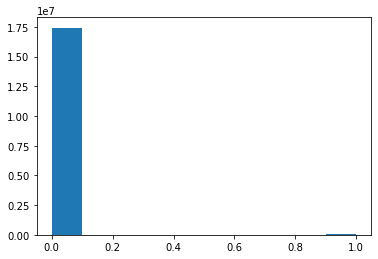

In [18]:
arr2 = np.array(current_image)
plt.hist(arr2.flatten())

(array([1.7388697e+07, 1.5685000e+04, 1.1048000e+04, 9.0750000e+03,
        8.6900000e+03, 8.6700000e+03, 8.6630000e+03, 9.7840000e+03,
        1.2980000e+04, 8.8308000e+04]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

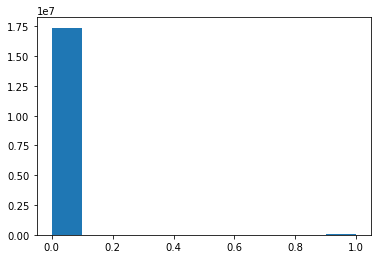

In [11]:
#arr1 = np.array(resampled)
#print(arr1.shape)
plt.hist(arr1.flatten())

In [17]:
# [STAR] For obtaining the surface mesh from Image

# resampled.astype(itk.F)

ft = itk.ThresholdImageFilter.IF3.New()
ft.SetInput(resampled.astype(itk.F))
ft.ThresholdBelow(0.5)
ft.SetOutsideValue(0)
ft.Update()

current_image1 = ft.GetOutput()

ft.SetInput(current_image1)
ft.ThresholdAbove(0.5)
ft.SetOutsideValue(1)
ft.Update()

current_image2 = ft.GetOutput()

a = itk.CuberilleImageToMeshFilter.IF3MF3.New()

a.SetInput(current_image2)
a.SetIsoSurfaceValue(1)
a.GenerateTriangleFacesOn()
a.ProjectVerticesToIsoSurfaceOn()
a.SetProjectVertexSurfaceDistanceThreshold(0.01)
a.SetProjectVertexMaximumNumberOfSteps(1000)
a.Update()

o = a.GetOutput()

#print(o)
itk.meshwrite(o, 'test2_thresh.vtk')

In [5]:
# [STAR] For obtaining the Largest Connected Component in a Mesh

f = itk.ConnectedRegionsMeshFilter.MF3MF3.New()
f.SetInput(o)
f.DebugOn()
f.SetExtractionModeToLargestRegion()
f.Update()
#out = f.GetOutput()

#print(f.GetNumberOfExtractedRegions())
#print(f.GetNumberOfInputs())
#print(f.GetNumberOfOutputs())

# out1 = f.GetOutputNames()

#itk.meshwrite(out, 'regions.vtk')

In [ ]:
# print(f.GetNumberOfExtractedRegions())
# print(f.GetNumberOfInputs())
# print(f.GetNumberOfOutputs())
out1 = f.GetOutputNames()
out = f.GetOutput()
itk.meshwrite(out, 'regions.vtk')

In [33]:
print("Number of Inputs ", f.GetNumberOfInputs())
print("Number of Outputs ", f.GetNumberOfOutputs())
print("Number of Extracted Regions ", f.GetNumberOfExtractedRegions())

Number of Inputs  1
Number of Outputs  1
Number of Extracted Regions  0


In [ ]:
# For printing the point Ids for all the cells in a Mesh

p = o.GetPoints()
c = o.GetCells()

#for i in range(p.Size()):
#    print(p.GetElement(i))

cells_numpy = np.zeros([c.Size(), 3])

for i in range(c.Size()):
    e = c.GetElement(i)
    pd = e.GetPointIdsContainer()
    pd_numpy = np.array(pd)
    cells_numpy[i] = pd_numpy


In [11]:
fc_prob = '/media/pranjal.sahu/cde12877-34df-449d-8202-07ba08ef2e6e/OLD/DATASETS/example_oai_data/example_data/OAI_results/9010060/MR_SAG_3D_DESS/LEFT_KNEE/12_MONTH/FC_probmap.nii.gz'
tc_prob = '/media/pranjal.sahu/cde12877-34df-449d-8202-07ba08ef2e6e/OLD/DATASETS/example_oai_data/example_data/OAI_results/9010060/MR_SAG_3D_DESS/LEFT_KNEE/12_MONTH/TC_probmap.nii.gz'

fc_mesh, tc_mesh = get_cartilage_surface_mesh_from_segmentation_file((fc_prob, tc_prob))

Extract surfaces


<ipython-input-10-61b7699dee85>:313: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  FC_verts, FC_faces, FC_normals, FC_values = measure.marching_cubes_lewiner(FC_prob, 0.5,
<ipython-input-10-61b7699dee85>:317: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  TC_verts, TC_faces, TC_normals, TC_values = measure.marching_cubes_lewiner(TC_prob, 0.5,


Compute FC mesh thickness
Reach maximum smoothing rings
thickness  (56710,) (62850,) (117542,)
Done computing FC mesh thickness
Compute TC mesh thickness
Well smoothed mesh segmentation
thickness  (18383,) (18895,) (36315,)
Done computing TC mesh thickness


In [9]:
#thick1 = fc_mesh.get_attribute("vertex_thickness")
print(thick1.shape)

(117542,)


In [32]:
fc_mesh.faces.size

705780

In [17]:
# Code For Testing the split_femoral_cartilage_surface method

#fc_prob_file = '/media/pranjal.sahu/cde12877-34df-449d-8202-07ba08ef2e6e/OLD/DATASETS/example_oai_data/example_data/OAI_results/9010060/MR_SAG_3D_DESS/LEFT_KNEE/12_MONTH/FC_probmap.nii.gz'
#tc_prob_file = '/media/pranjal.sahu/cde12877-34df-449d-8202-07ba08ef2e6e/OLD/DATASETS/example_oai_data/example_data/OAI_results/9010060/MR_SAG_3D_DESS/LEFT_KNEE/12_MONTH/TC_probmap.nii.gz'

fc_prob_file = '/media/pranjal.sahu/cde12877-34df-449d-8202-07ba08ef2e6e/OLD/DATASETS/example_oai_data/example_data/OAI_results/9010060/MR_SAG_3D_DESS/LEFT_KNEE/96_MONTH/FC_probmap.nii.gz'
tc_prob_file = '/media/pranjal.sahu/cde12877-34df-449d-8202-07ba08ef2e6e/OLD/DATASETS/example_oai_data/example_data/OAI_results/9010060/MR_SAG_3D_DESS/LEFT_KNEE/96_MONTH/TC_probmap.nii.gz'


segmentation_file =  (fc_prob_file, tc_prob_file)

segmentation = [sitk.ReadImage(file) for file in segmentation_file]
FC_prob = np.swapaxes(sitk.GetArrayFromImage(segmentation[0]), 0, 2).astype(float)
TC_prob = np.swapaxes(sitk.GetArrayFromImage(segmentation[1]), 0, 2).astype(float)

coord = 'voxel'

# the np array from itk are ordered in z,y,x
if coord == 'voxel':
    transform = None
elif coord == 'nifti':
    transform = get_voxel_to_world_transform_nifti(segmentation[0])
spacing = segmentation[0].GetSpacing()


# get_cartilage_surface_mesh_from_segmentation_array(FC_prob, TC_prob,
#                                                   spacing=spacing,
#                                                   thickness=thickness,
#                                                   save_path_TC=save_path_TC,
#                                                   save_path_FC=save_path_FC,
#                                                   prob=prob,
#                                                   transform=transform)

thickness = True
prob = True


print("Extract surfaces")
FC_verts, FC_faces, FC_normals, FC_values = measure.marching_cubes_lewiner(FC_prob, 0.5,
                                                                           spacing=spacing,
                                                                           step_size=1, 
                                                                           gradient_direction="ascent")

TC_verts, TC_faces, TC_normals, TC_values = measure.marching_cubes_lewiner(TC_prob, 0.5,
                                                                           spacing=spacing,
                                                                           step_size=1, 
                                                                           gradient_direction="ascent")

FC_mesh = pymesh.form_mesh(FC_verts, FC_faces)
TC_mesh = pymesh.form_mesh(TC_verts, TC_faces)

FC_mesh, _ = pymesh.remove_duplicated_vertices(FC_mesh)
TC_mesh, _ = pymesh.remove_duplicated_vertices(TC_mesh)

FC_mesh_main = get_main_mesh(pymesh.separate_mesh(FC_mesh), threshold=1000, merge=True)
TC_mesh_main = get_main_mesh(pymesh.separate_mesh(TC_mesh), threshold=1000, merge=True)


# smooth_rings = 10
# max_rings = None

# inner_mesh, outer_mesh, inner_face_list, outer_face_list = split_femoral_cartilage_surface(FC_mesh_main,
#                                                                                         smooth_rings=smooth_rings,
#                                                                                         max_rings=max_rings,
#                                                                                         n_workers=1)

smooth_rings = 5
max_rings = None
inner_mesh, outer_mesh, inner_face_list, outer_face_list = split_tibial_cartilage_surface(TC_mesh_main,
                                                                                          smooth_rings=smooth_rings,
                                                                                          max_rings=max_rings,
                                                                                          n_workers=1)

FC_thickness = compute_mesh_thickness(FC_mesh_main, cartilage='FC', smooth_rings=10, max_rings=None,
                                              n_workers=1)

Extract surfaces


<ipython-input-17-559571777e9a>:39: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  FC_verts, FC_faces, FC_normals, FC_values = measure.marching_cubes_lewiner(FC_prob, 0.5,
<ipython-input-17-559571777e9a>:44: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  TC_verts, TC_faces, TC_normals, TC_values = measure.marching_cubes_lewiner(TC_prob, 0.5,


Reach maximum smoothing rings


In [ ]:
#plot_mesh_segmentation(FC_mesh_main, TC_mesh_main)
plot_mesh_segmentation(inner_mesh, outer_mesh)

In [8]:
import vtk
from itkwidgets import view


mr1 = vtk.vtkPolyDataReader()
mr1.SetFileName("test1.vtk")
mr1.Update()
o1 = mr1.GetOutput()

mr1.SetFileName("test2_thresh.vtk")
mr1.Update()
o2 = mr1.GetOutput()


mr1.SetFileName("regions.vtk")
mr1.Update()
o3 = mr1.GetOutput()


#view(geometries=[o1, o2])
view(geometries=o2)
#view(geometries=out)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…